# Astrometric analysis with ePSF (ace001-image00)

## Importing some modules

In [73]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pf
from astropy.visualization import simple_norm

## Loading image

Text(0, 0.5, 'Y (px)')

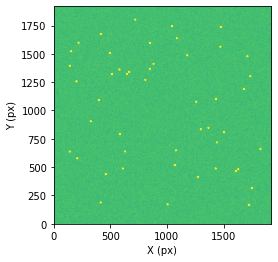

In [74]:
hdu = pf.open("image00.fits")[0]
data = hdu.data.astype(np.float32)
norm = simple_norm(data, 'sqrt', percent=99.)
plt.imshow(data, norm=norm, origin='lower', cmap='viridis')
plt.xlabel('X (px)')
plt.ylabel('Y (px)')

## Finding peaks with photutils.detection.find_peaks

In [75]:
from photutils.detection import find_peaks
peaks_tbl = find_peaks(data, threshold=500.)
peaks_tbl['peak_value'].info.format = '%.8g'  # for consistent table output
print(peaks_tbl)

x_peak y_peak peak_value
------ ------ ----------
  1719    168       2872
   999    173       2716
   410    189       2735
  1740    317       2765
  1265    416       2647
   454    439       2674
  1600    466       2671
  1623    482       2810
   606    488       2636
  1423    489       2526
   ...    ...        ...
  1172   1485       2907
   492   1506       2944
   151   1521       2986
  1465   1561       2953
   846   1595       2827
   215   1596       2861
  1081   1634       2933
   412   1674       3099
  1470   1735       2738
  1039   1741       3057
   716   1800       2922
Length = 48 rows


## Removing data in edge regions

In [76]:
mask_size = 25 
hsize = (mask_size - 1) / 2
x = peaks_tbl['x_peak'] 
y = peaks_tbl['y_peak'] 
mask = ((x > hsize) & (x < (data.shape[1] -1 - hsize)) &
        (y > hsize) & (y < (data.shape[0] -1 - hsize)))
print(peaks_tbl[mask])

x_peak y_peak peak_value
------ ------ ----------
  1719    168       2872
   999    173       2716
   410    189       2735
  1740    317       2765
  1265    416       2647
   454    439       2674
  1600    466       2671
  1623    482       2810
   606    488       2636
  1423    489       2526
   ...    ...        ...
  1172   1485       2907
   492   1506       2944
   151   1521       2986
  1465   1561       2953
   846   1595       2827
   215   1596       2861
  1081   1634       2933
   412   1674       3099
  1470   1735       2738
  1039   1741       3057
   716   1800       2922
Length = 48 rows


In [77]:
from astropy.table import Table
stars_tbl = Table()
stars_tbl['x'] = x[mask] 
stars_tbl['y'] = y[mask]

## Subtracting background

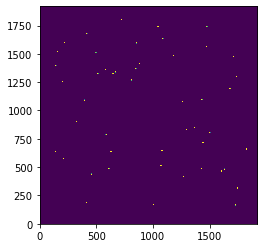

In [78]:
from astropy.stats import sigma_clipped_stats
from photutils.background import MMMBackground
import copy
mean_val, median_val, std_val = sigma_clipped_stats(data, sigma=2.)  
image = copy.deepcopy(data)
data -= mean_val
plt.imshow(data, norm=norm, origin='lower', cmap='viridis')

## Extracting stellar images

In [79]:
from astropy.nddata import NDData
nddata = NDData(data=data)  
print(nddata.data.shape)

(1920, 1920)


In [80]:
from photutils.psf import extract_stars
size = 9
stars = extract_stars(nddata, stars_tbl, size=size)

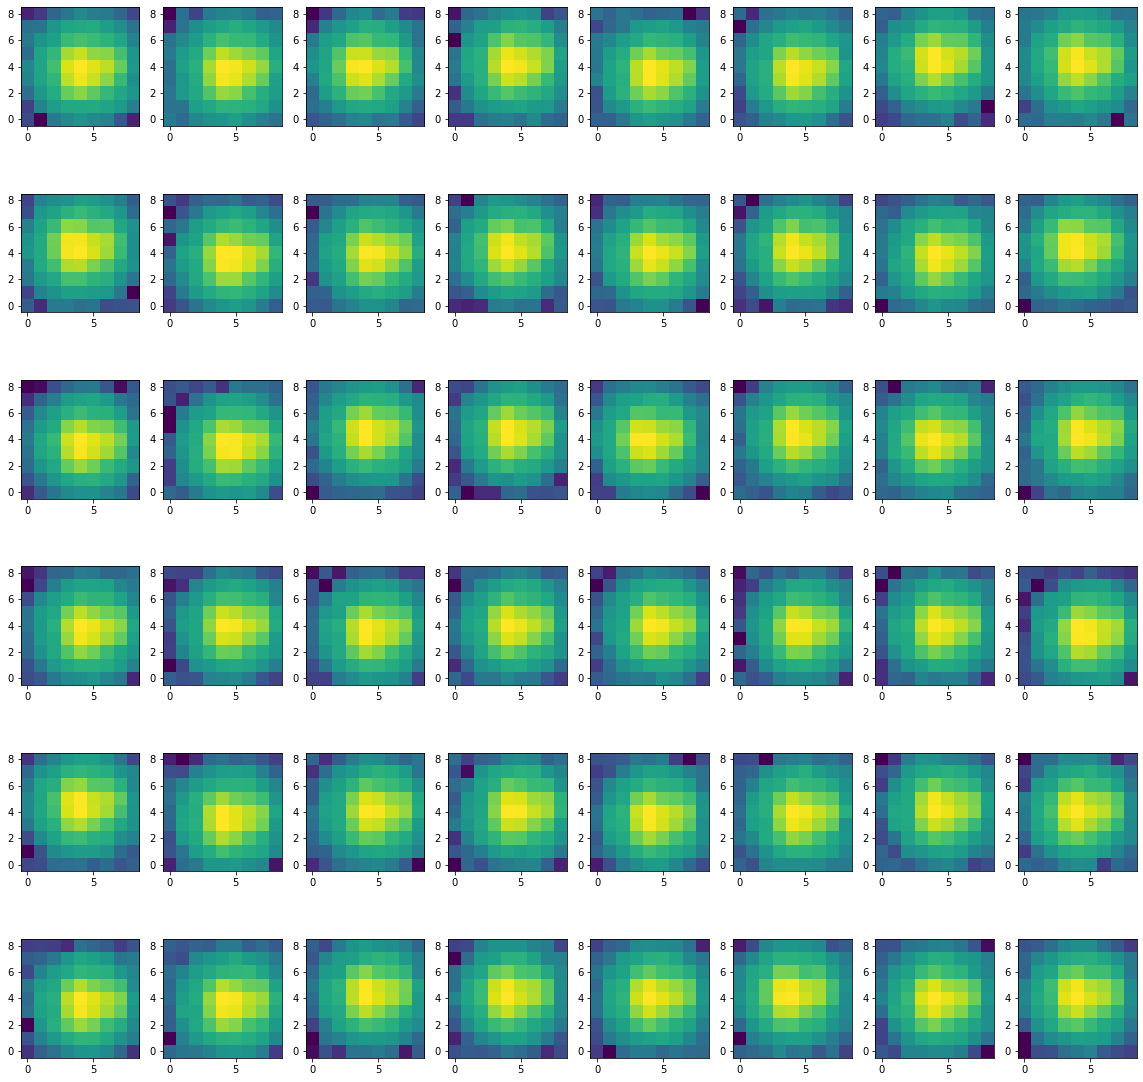

In [81]:
nrows = 6
ncols = 8
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20), squeeze=True)
ax = ax.ravel()
for i in range(nrows*ncols):
    norm = simple_norm(stars[i], 'log', percent=99.)
    ax[i].imshow(stars[i], norm=norm, origin='lower', cmap='viridis')

## Making ePSF data

In [82]:
from photutils.psf import EPSFBuilder
epsf_builder = EPSFBuilder(oversampling=4, maxiters=3, progress_bar=True)
epsf, fitted_stars = epsf_builder(stars)

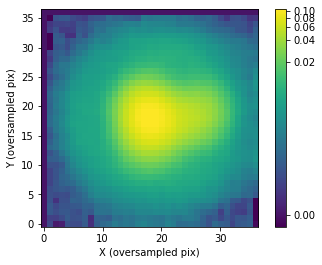

In [83]:
norm = simple_norm(epsf.data, 'log', percent=99.)
plt.imshow(epsf.data, norm=norm, origin='lower', cmap='viridis')
plt.xlabel('X (oversampled pix)')
plt.ylabel('Y (oversampled pix)')
plt.colorbar()

## Checking radial profile

Text(0, 0.5, 'Signal (a.u.)')

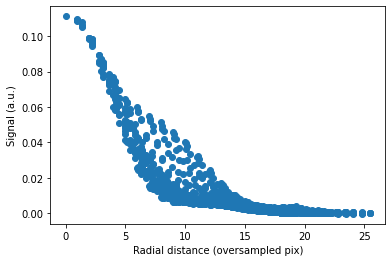

In [84]:
shape = np.shape(epsf.data)
iy, ix = np.indices(shape)
dy = iy - (shape[0]-1)*0.5
dx = ix - (shape[1]-1)*0.5
d = np.sqrt(dx**2.+dy**2.)
plt.scatter(d.flatten(), epsf.data.flatten())
plt.xlabel('Radial distance (oversampled pix)')
plt.ylabel('Signal (a.u.)')

## Gaussian fitting of the core profile

Text(0, 0.5, 'Signal (a.u.)')

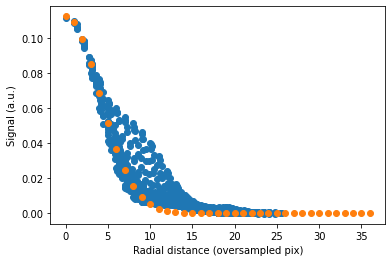

In [85]:
import warnings
from astropy.modeling import models, fitting

# Fit the data using a Gaussian
g_init = models.Gaussian1D(amplitude=.1, mean=0, stddev=1.)
fit_g = fitting.LevMarLSQFitter()
pos = np.where(d.flatten()<5.)
g = fit_g(g_init, d.flatten()[pos], epsf.data.flatten()[pos])

plt.scatter(d.flatten(), epsf.data.flatten())
x=np.arange(0,shape[0])
plt.scatter(x, g(x))
plt.xlabel('Radial distance (oversampled pix)')
plt.ylabel('Signal (a.u.)')

In [86]:
g

<Gaussian1D(amplitude=0.11237755, mean=0.00362462, stddev=4.00918628)>

stddev = 4.0 (oversampled) -> 1 (original sampling).

## Comparing stellar positions with input catalog

### Loading the input catalog

In [87]:
original = np.loadtxt("../../../../analysis/star_plate_sorted.dat")

This is inversely sorted with y-pix.

### Plotting the positions

(0.0, 1920.0)

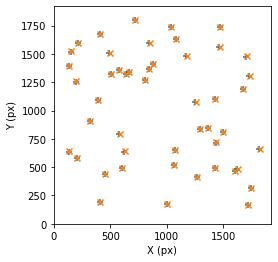

In [88]:
plt.axes().set_aspect('equal')
plt.scatter(fitted_stars.center_flat[:,0], fitted_stars.center_flat[:,1], marker='+', label='Fitted')
plt.scatter(original[:,2], original[:,3], marker='x', label='Input')
plt.xlabel('X (px)')
plt.ylabel('Y (px)')
plt.xlim([0, 1920])
plt.ylim([0, 1920])

### Plotting positional difference

Text(0, 0.5, '$\\Delta$y (px)')

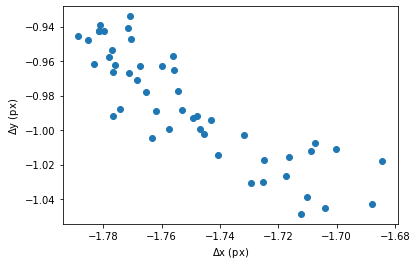

In [89]:
plt.scatter(fitted_stars.center_flat[::-1,0]-original[:,2], fitted_stars.center_flat[::-1,1]-original[:,3])
plt.xlabel('$\Delta$x (px)')
plt.ylabel('$\Delta$y (px)')

## Applying PSF photometry to fit the ePSF to the stellar images

In [90]:
from photutils.detection import DAOStarFinder, IRAFStarFinder
from photutils.psf import DBSCANGroup
from photutils.psf import IntegratedGaussianPRF
from photutils.background import MMMBackground
from photutils.background import MADStdBackgroundRMS
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.stats import gaussian_sigma_to_fwhm

bkgrms = MADStdBackgroundRMS()

std = bkgrms(image)

sigma_psf = 1.0

iraffind = IRAFStarFinder(threshold=2000.,
                          fwhm=sigma_psf*gaussian_sigma_to_fwhm,
                          minsep_fwhm=0.01, roundhi=5.0, roundlo=-5.0,
                          sharplo=0.0, sharphi=2.0)

grouper = DBSCANGroup(2.0*sigma_psf*gaussian_sigma_to_fwhm)

mmm_bkg = MMMBackground()

psf_model = epsf

fitter = LevMarLSQFitter()

In [91]:
from photutils.psf import IterativelySubtractedPSFPhotometry

photometry = IterativelySubtractedPSFPhotometry(finder=iraffind, group_maker=grouper,
                                                bkg_estimator=mmm_bkg, psf_model=psf_model,
                                                fitter=LevMarLSQFitter(),
                                                niters=2, fitshape=(size,size))
result_tab = photometry(image)
residual_image = photometry.get_residual_image()

## Checking the result

### Plotting measured positions in the global coordinates

(0.0, 1920.0)

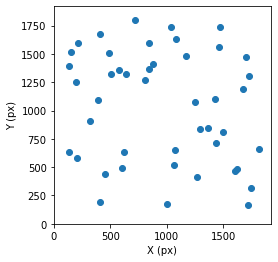

In [92]:
plt.axes().set_aspect('equal')
plt.scatter(result_tab['x_fit'], result_tab['y_fit'])
plt.xlabel('X (px)')
plt.ylabel('Y (px)')
plt.xlim([0, 1920])
plt.ylim([0, 1920])

### Checking the positional differences

Here, we remove some points that were not successfully analysed.

In [93]:
mabiki = np.delete(original, -9, 0)
mabiki = np.delete(mabiki, -17, 0)
mabiki = np.delete(mabiki, -30, 0)
mabiki = np.delete(mabiki, -9, 0)
del result_tab[8]

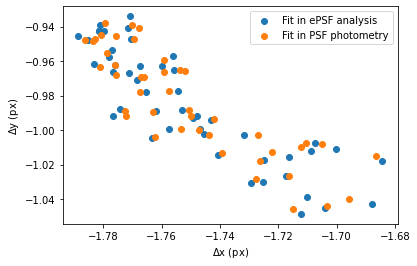

In [94]:
plt.scatter(fitted_stars.center_flat[::-1,0]-original[:,2], fitted_stars.center_flat[::-1,1]-original[:,3], label='Fit in ePSF analysis')
plt.scatter(result_tab['x_fit']-mabiki[::-1,2], result_tab['y_fit']-mabiki[::-1,3], label='Fit in PSF photometry')
plt.xlabel('$\Delta$x (px)')
plt.ylabel('$\Delta$y (px)')
plt.legend()

### Checking the positional differences in vector plot

In [96]:
dx = result_tab['x_fit']-mabiki[::-1,2]
dy = result_tab['y_fit']-mabiki[::-1,3]

dx = dx - np.mean(dx)
dy = dy - np.mean(dy)

Here, we subtracted the average values of the positional differences to omit the global offset caused by the ACE effect.
The ACE is offset to make its average value to be zero, and the first value is not zero usually.
The average ACE is expected to be non-zero value, and it also offsets the stellar positions on the detector globally.

(0.0, 1920.0)

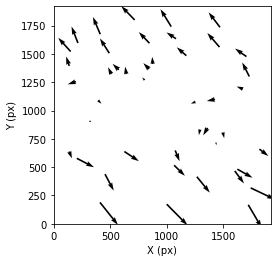

In [100]:
plt.axes().set_aspect('equal')
plt.quiver(result_tab['x_fit'], result_tab['y_fit'], dx, dy, angles='xy', scale_units='xy', scale=0.0003)
plt.xlabel('X (px)')
plt.ylabel('Y (px)')
plt.xlim([0, 1920])
plt.ylim([0, 1920])